<a href="https://colab.research.google.com/github/Vahe0795/Machine-Learning/blob/main/People_image_classification_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
from google.colab import drive

drive.mount('/content/drive')
!ls/content/drive/MyDrive/Chess
os.chdir('/content/drive/MyDrive/People')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: ls/content/drive/MyDrive/Chess: No such file or directory


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import cv2

In [3]:
from pathlib import Path
data_dir = Path('/content/drive/MyDrive/People')
data_dir


PosixPath('/content/drive/MyDrive/People')

In [4]:
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

4830


In [5]:
batch_size = 32

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=batch_size)

Found 4830 files belonging to 4 classes.
Using 3864 files for training.


In [7]:
val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(224, 224),
  batch_size=batch_size)

Found 4830 files belonging to 4 classes.
Using 966 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Boys', 'Girls', 'Men', 'Women']


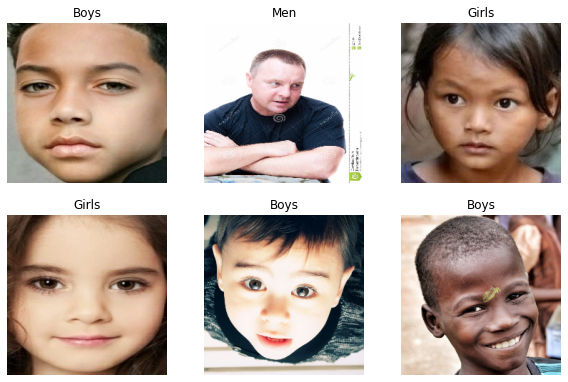

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"));
        plt.title(class_names[labels[i]]);
        plt.axis("off");

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [11]:
from tensorflow.keras.layers import Rescaling
normalization_layer = Rescaling(1./255)

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
normalized_ds_1 = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds_1))
first_image = image_batch[0]
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16 
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [20]:
def my_model(num_classes = 4):    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((224, 224, 3)))
    model.add(vgg)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    # model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense((num_classes), activation='softmax'))


    tf.keras.backend.clear_session()
    
    model.compile(
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
    )

    return model

model = my_model()

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 17,927,108
Trainable params: 3,212,164
Non-trainable params: 14,714,944
____________________________________

In [22]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
121/121 [==============================] - 2271s 19s/step - loss: 0.4901 - accuracy: 0.8344 - val_loss: 0.3135 - val_accuracy: 0.8986
Epoch 2/10
121/121 [==============================] - 2193s 18s/step - loss: 0.0925 - accuracy: 0.9801 - val_loss: 0.2813 - val_accuracy: 0.9048
Epoch 3/10
121/121 [==============================] - 2203s 18s/step - loss: 0.0409 - accuracy: 0.9902 - val_loss: 0.2950 - val_accuracy: 0.9017
Epoch 4/10
121/121 [==============================] - 2197s 18s/step - loss: 0.0213 - accuracy: 0.9930 - val_loss: 0.3018 - val_accuracy: 0.9058
Epoch 5/10
121/121 [==============================] - 2194s 18s/step - loss: 0.0103 - accuracy: 0.9977 - val_loss: 0.3024 - val_accuracy: 0.9048
Epoch 6/10
121/121 [==============================] - 2181s 18s/step - loss: 0.0072 - accuracy: 0.9987 - val_loss: 0.3104 - val_accuracy: 0.9120
Epoch 7/10
121/121 [==============================] - 2158s 18s/step - loss: 0.0041 - accuracy: 0.9995 - val_loss: 0.3128 - val_ac

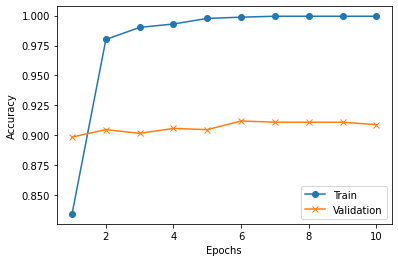

In [23]:
epochs_range = [i+1 for i in range(epochs)]
plt.plot(epochs_range, model.history.history['accuracy'], '-o', label='Train')
plt.plot(epochs_range, model.history.history['val_accuracy'], '-x',label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend();

In [24]:
label = np.array([])
for prediction, labels in val_ds:
  label = np.concatenate([label, labels.numpy()])
label


array([3., 1., 3., 2., 1., 2., 1., 2., 1., 1., 0., 0., 0., 3., 2., 2., 2.,
       3., 0., 2., 3., 3., 2., 3., 3., 0., 3., 3., 3., 2., 2., 2., 2., 1.,
       2., 3., 2., 2., 2., 2., 3., 2., 2., 3., 0., 3., 2., 3., 1., 3., 1.,
       2., 1., 2., 2., 2., 0., 2., 2., 3., 2., 2., 1., 1., 0., 3., 3., 3.,
       2., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 0., 2., 0., 3., 3.,
       3., 2., 0., 3., 1., 3., 2., 3., 2., 1., 2., 3., 2., 3., 2., 3., 0.,
       2., 2., 2., 2., 3., 2., 2., 1., 1., 2., 1., 0., 1., 3., 3., 2., 1.,
       3., 0., 1., 2., 3., 3., 1., 2., 2., 0., 3., 2., 3., 1., 3., 1., 3.,
       3., 2., 1., 3., 0., 2., 3., 2., 3., 0., 2., 3., 2., 3., 3., 3., 2.,
       3., 2., 0., 1., 3., 0., 2., 3., 3., 2., 3., 3., 2., 0., 3., 2., 1.,
       0., 2., 3., 2., 3., 0., 3., 3., 2., 1., 3., 2., 0., 2., 3., 2., 1.,
       1., 2., 2., 2., 1., 0., 1., 3., 3., 3., 2., 3., 3., 2., 2., 2., 0.,
       3., 2., 3., 1., 2., 0., 2., 2., 1., 2., 1., 1., 1., 2., 0., 2., 1.,
       2., 0., 3., 3., 2.

In [26]:
Y_pred = model.predict(val_ds, 966 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

In [42]:
from sklearn.metrics import confusion_matrix

matrix1 = confusion_matrix(label, y_pred)

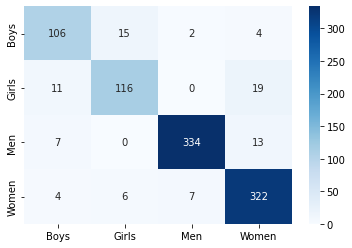

In [43]:
import seaborn as sns
sns.heatmap(matrix1, annot=True, cmap='Blues', yticklabels=class_names, xticklabels=class_names, fmt='g');

In [44]:
from sklearn.metrics import accuracy_score
score = accuracy_score(label, y_pred)
score

0.9089026915113871